In [10]:
import os
from src.module import Module
from src.dm import DataModule
import torchmetrics
import torch
import matplotlib.pyplot as plt
from einops import rearrange

In [2]:
checkpoints = os.listdir('./checkpoints')
checkpoints

['fc_t5_efficientnet_b0_da2_512-val_metric=0.60553-epoch=62.ckpt',
 'fc_temp_resnet34-val_metric=0.59515-epoch=91.ckpt',
 'fc_t5_efficientnet_b0_da2_512-epoch=67.ckpt',
 'fc_t5_seresnextaa101d_32x8d_512-val_metric=0.58112-epoch=72.ckpt',
 'fc_t5_efficientnet_b0_da_512-val_metric=0.61805-epoch=293.ckpt']

In [3]:
checkpoint = 'checkpoints/fc_t5_efficientnet_b0_da_512-val_metric=0.61805-epoch=293.ckpt'
module = Module.load_from_checkpoint(checkpoint, map_location='cpu')

In [5]:
dm = DataModule(batch_size=10, false_color=True, t=[4], val_trans={'Resize': {"height":512, 'width':512}})
dm.setup()

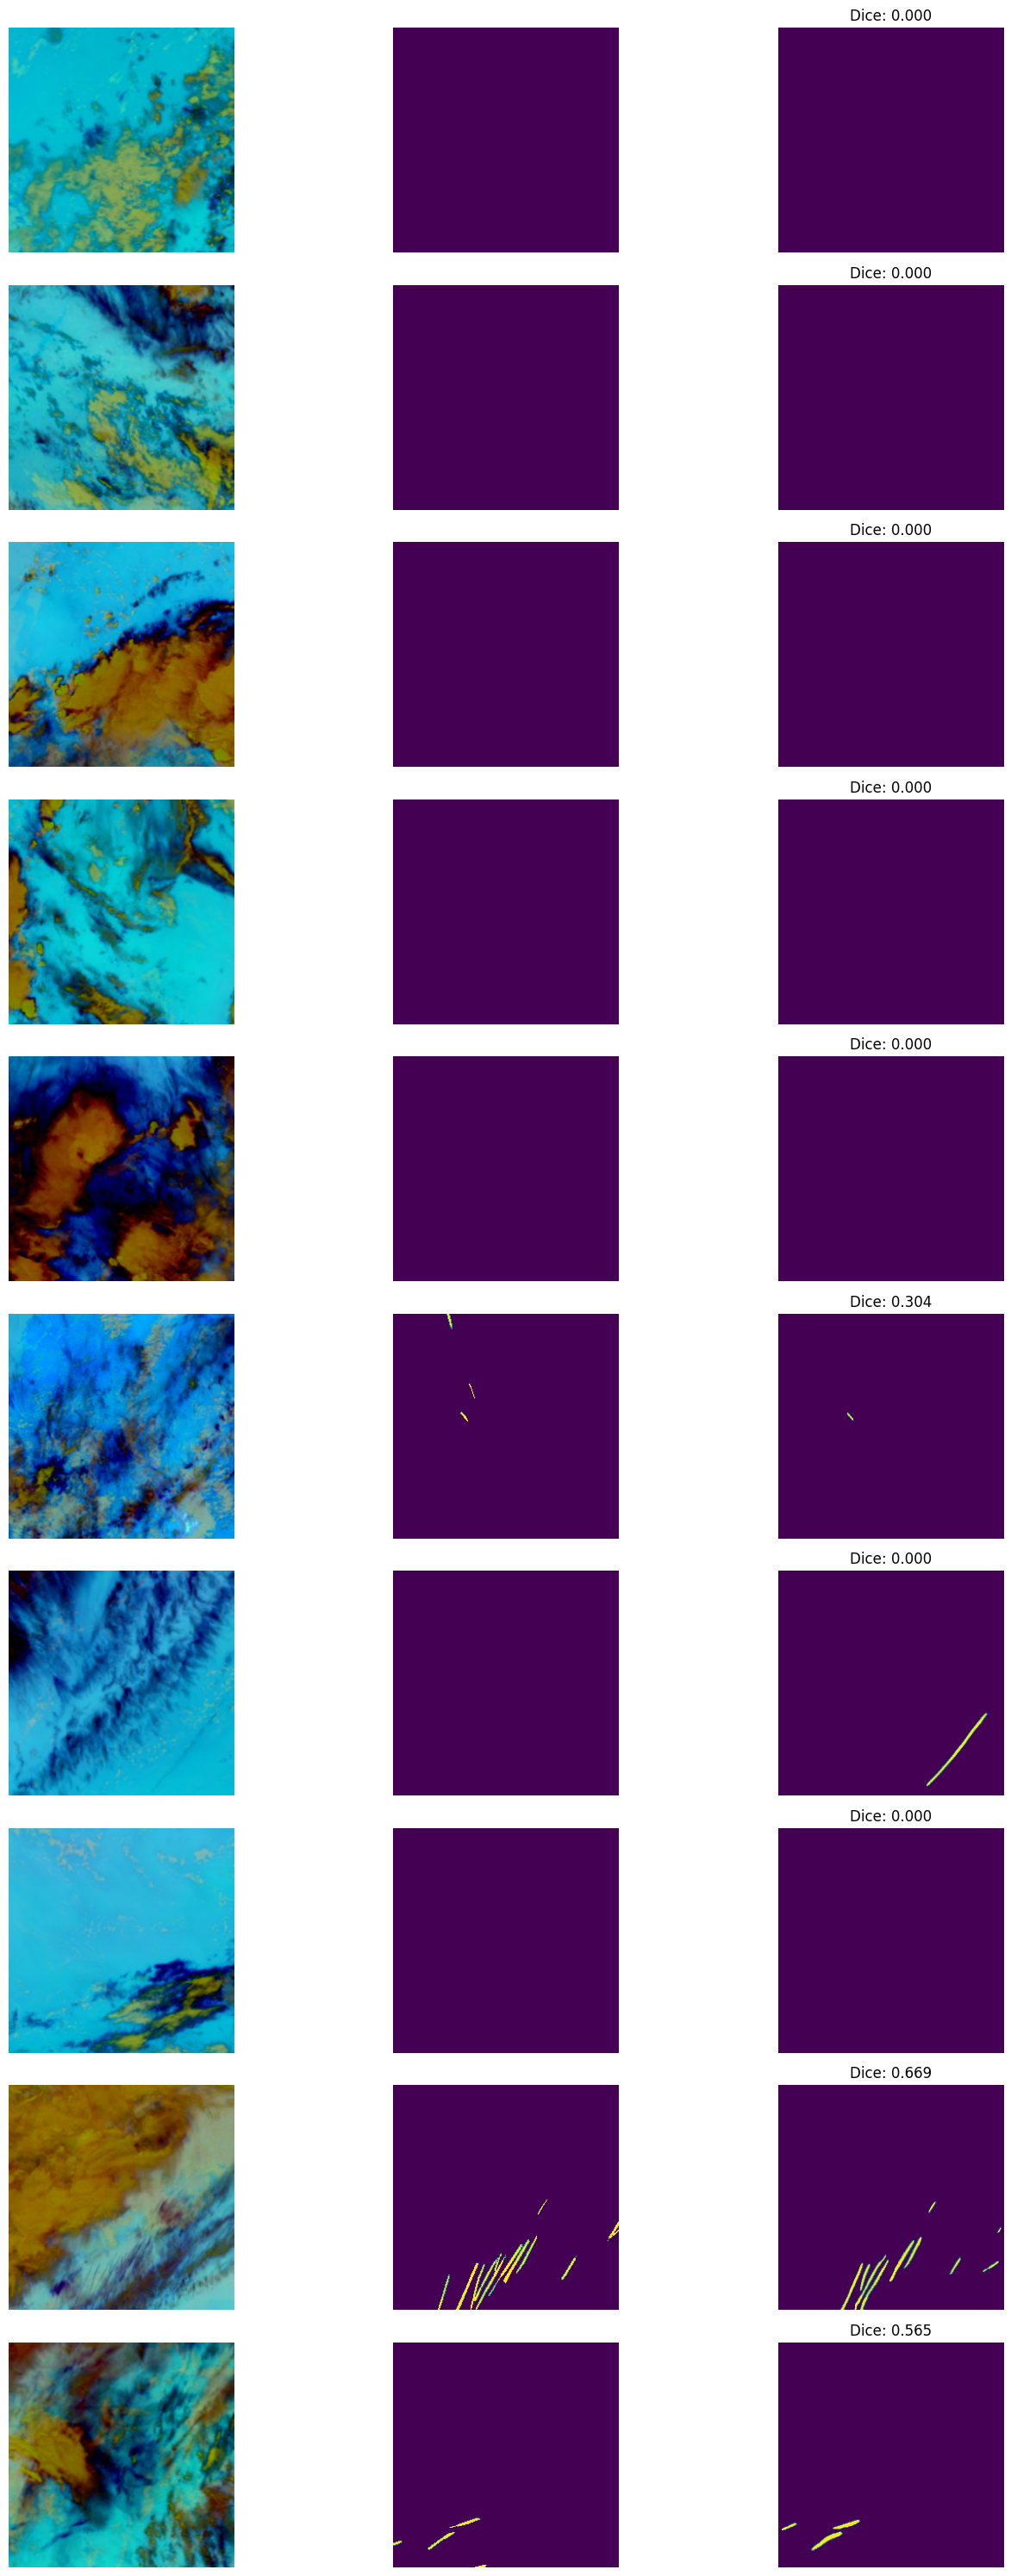

In [34]:
module.eval()
module.cuda(1)
metric = torchmetrics.Dice().cuda(1)
batch = next(iter(dm.val_dataloader(shuffle=True)))
fig = plt.figure(figsize=(15, 30))
with torch.no_grad():
	x, y, y0 = batch
	y_hat = module(x.cuda(1))
	probas = torch.sigmoid(y_hat) > 0.5 
	probas = torch.nn.functional.interpolate(probas.float(), size=y0.shape[-2:], mode='bilinear')
	y0 = y0.cuda(1)
	for i in range(probas.shape[0]):
		dice = metric(probas[i:i+1], y0[i:i+1])
		ax = fig.add_subplot(10, 3, 3*i+1)
		ax.imshow(rearrange(x[i], 'h w t c -> h w (t c)').cpu().numpy())
		ax.axis('off')
		ax = fig.add_subplot(10, 3, 3*i+2)
		ax.imshow(y0[i].cpu().numpy())
		ax.axis('off')
		ax = fig.add_subplot(10, 3, 3*i+3)
		ax.imshow(probas[i,0].cpu().numpy())
		ax.axis('off')
		ax.set_title(f'Dice: {dice.item():.3f}')
plt.tight_layout()
plt.show()

In [35]:
metric(probas, y0).item()

0.5754386186599731